<a href="https://colab.research.google.com/github/annulet/CNN_NVIDIA/blob/master/hw_8_Generation_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализовать синтезирование лиц из LFW с помощью DCGAN.
 Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

## Загрузка и подготовка датасета MNIST

In [0]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

train_x = (train_x.reshape(-1, 28*28).astype(np.float32) - 127.5) / 127.5

print(train_x.shape, train_x.dtype)
print(np.min(train_x), np.max(train_x))

11493376/11490434 [==============================] - 0s 0us/step
(60000, 784) float32
-1.0 1.0


## Визуализация датасета MNIST

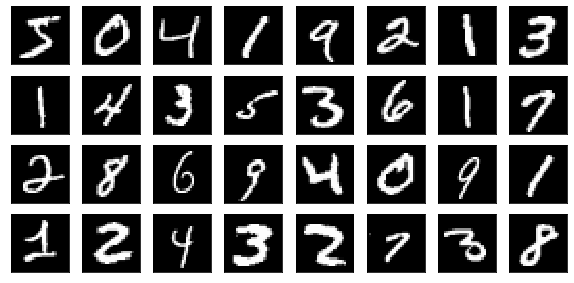

In [0]:
def plot_digits(samples):
    fig = plt.figure(figsize=(10, 10))
    num = samples.shape[0]
    for j in range(num):
        ax = fig.add_subplot(8, 8, j+1)
        ax.imshow(samples[j, ...].reshape(28, 28), cmap='gray')
        plt.xticks([]), plt.yticks([])
    plt.show()
    
plot_digits(train_x[:32, ...])

## Создание Генератора и Дискриминатора

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(256),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dense(512),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dense(1024),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.Dense(784, activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Dense(784),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dense(392),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dense(1),
])

## Подготовка пайплайна данных и оптимизатора

In [0]:
INPUT_DIM = 100
NUM_EPOCHS = 5
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x)
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Обучение GAN

[Step  0] D Loss: 0.7935; G Loss: 0.7868


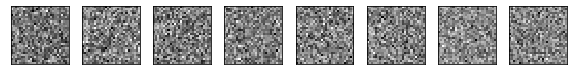

[Step 500] D Loss: 0.1922; G Loss: 10.1456


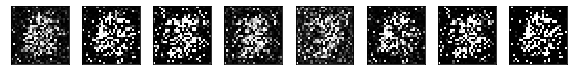

[Step 1000] D Loss: 0.4871; G Loss: 1.6506


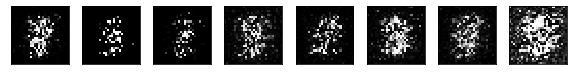

[Step 1500] D Loss: 0.3655; G Loss: 2.1592


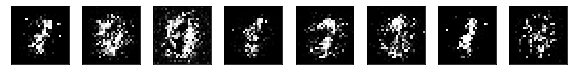

[Step 2000] D Loss: 0.2607; G Loss: 1.8468


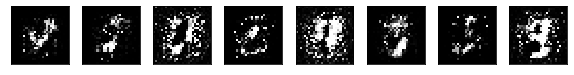

[Step 2500] D Loss: 0.4843; G Loss: 1.5044


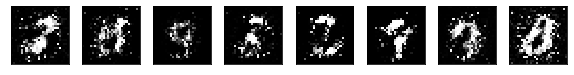

[Step 3000] D Loss: 0.3949; G Loss: 1.3675


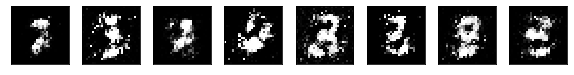

[Step 3500] D Loss: 0.6228; G Loss: 1.0760


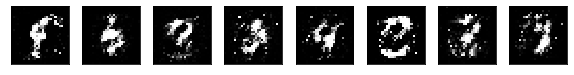

[Step 4000] D Loss: 0.6689; G Loss: 2.1625


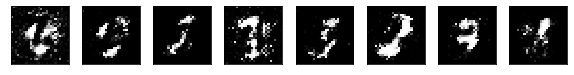

[Step 4500] D Loss: 0.4047; G Loss: 1.7198


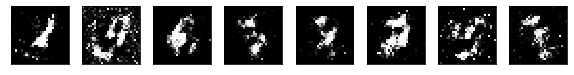

[Step 5000] D Loss: 0.4618; G Loss: 1.8384


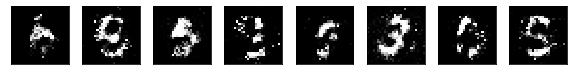

[Step 5500] D Loss: 0.5734; G Loss: 0.7546


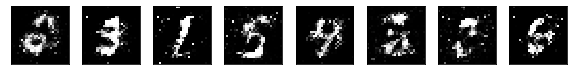

[Step 6000] D Loss: 0.4028; G Loss: 1.2002


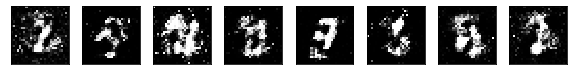

[Step 6500] D Loss: 0.5185; G Loss: 0.8117


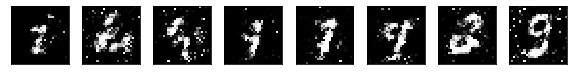

[Step 7000] D Loss: 0.5569; G Loss: 1.9346


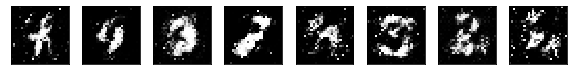

[Step 7500] D Loss: 0.4773; G Loss: 2.0228


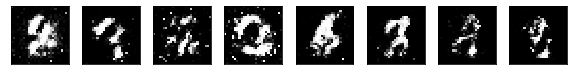

[Step 8000] D Loss: 0.4841; G Loss: 1.1538


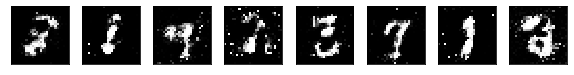

[Step 8500] D Loss: 0.5081; G Loss: 0.7136


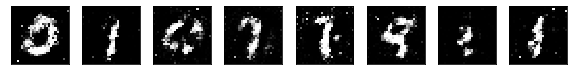

[Step 9000] D Loss: 0.4756; G Loss: 1.0888


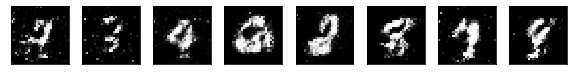

[Step 9500] D Loss: 0.4285; G Loss: 0.9998


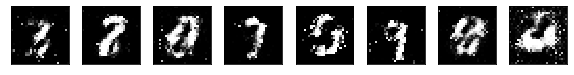

[Step 10000] D Loss: 0.4765; G Loss: 1.4216


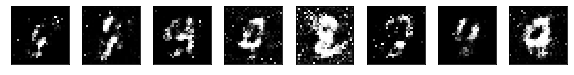

[Step 10500] D Loss: 0.4375; G Loss: 1.8597


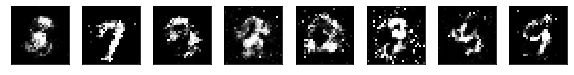

[Step 11000] D Loss: 0.6107; G Loss: 0.8571


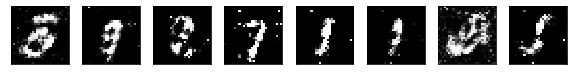

[Step 11500] D Loss: 0.7648; G Loss: 1.9589


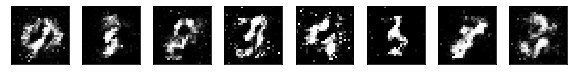

[Step 12000] D Loss: 0.4419; G Loss: 1.1365


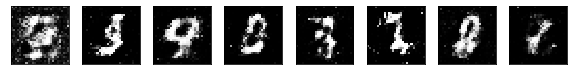

[Step 12500] D Loss: 0.3809; G Loss: 1.4182


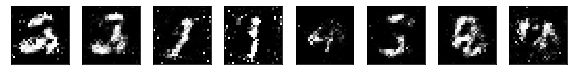

[Step 13000] D Loss: 0.7876; G Loss: 0.9623


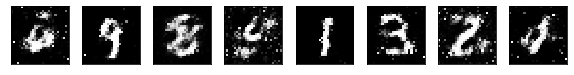

[Step 13500] D Loss: 0.4902; G Loss: 1.6556


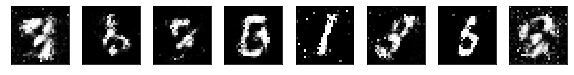

[Step 14000] D Loss: 0.6526; G Loss: 0.8868


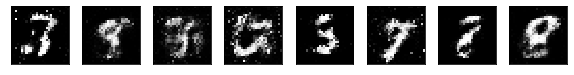

[Step 14500] D Loss: 0.6515; G Loss: 1.2701


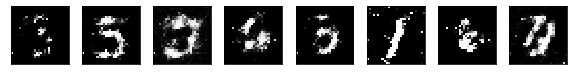

[Step 15000] D Loss: 0.3728; G Loss: 0.9267


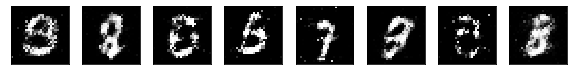

[Step 15500] D Loss: 0.5947; G Loss: 2.2659


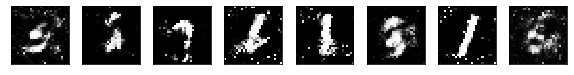

[Step 16000] D Loss: 0.5936; G Loss: 1.2792


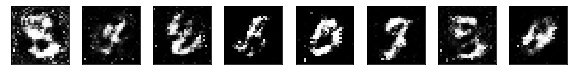

[Step 16500] D Loss: 0.5566; G Loss: 0.8418


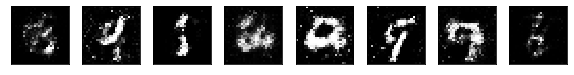

[Step 17000] D Loss: 0.6548; G Loss: 1.4283


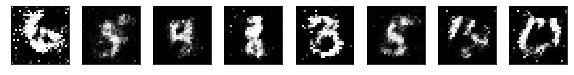

[Step 17500] D Loss: 0.5982; G Loss: 1.5143


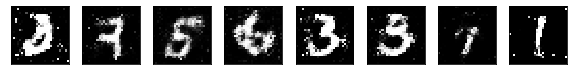

[Step 18000] D Loss: 0.4954; G Loss: 1.2648


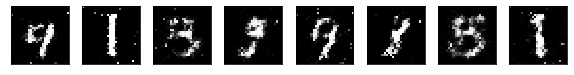

[Step 18500] D Loss: 0.6315; G Loss: 1.1060


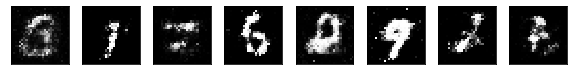

In [0]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        logits = discriminator(generator(noise, training=True))
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 500 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Тестирование генератора

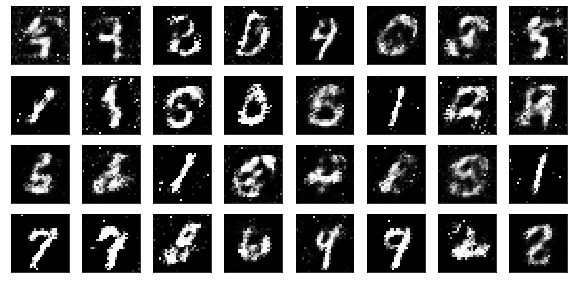

In [0]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Интерполяция в латентном пространстве

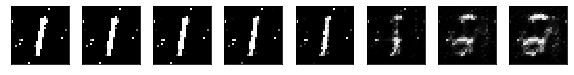

In [0]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Deep Convolutional GAN (DCGAN)

In [0]:
generator = tf.keras.Sequential([
    tf.keras.layers.Dense(128*7*7, activation='relu'),
    tf.keras.layers.Reshape((7, 7, 128)),
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.UpSampling2D((2, 2)),    
    tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.ReLU(),    
    tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='tanh'),
])

discriminator = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), strides=(2, 2), padding='same'),
    tf.keras.layers.LeakyReLU(0.2),
    tf.keras.layers.Dropout(0.25),    
    tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.ZeroPadding2D(padding=((0, 1), (0, 1))),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(256, kernel_size=3, strides=(1, 1), padding='same'),
    tf.keras.layers.BatchNormalization(momentum=0.8),
    tf.keras.layers.LeakyReLU(alpha=0.2),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1),
])

In [0]:
INPUT_DIM = 100
NUM_EPOCHS = 2
HALF_BATCH_SIZE = 16
BATCH_SIZE = HALF_BATCH_SIZE * 2
LEARNING_RATE = 0.0002

train_ds = tf.data.Dataset.from_tensor_slices(train_x.reshape(-1, 28, 28, 1))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(HALF_BATCH_SIZE, drop_remainder=True)

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
sigmoid_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

[Step  0] D Loss: 0.8171; G Loss: 0.7017


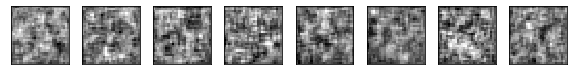

[Step 200] D Loss: 0.4245; G Loss: 2.8692


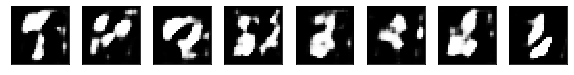

[Step 400] D Loss: 1.1851; G Loss: 0.9592


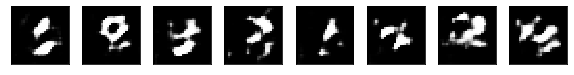

[Step 600] D Loss: 0.5472; G Loss: 1.8438


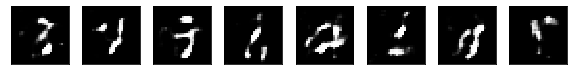

[Step 800] D Loss: 0.7522; G Loss: 1.0014


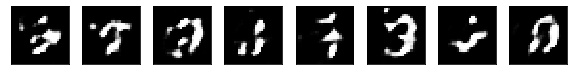

[Step 1000] D Loss: 0.5900; G Loss: 0.9983


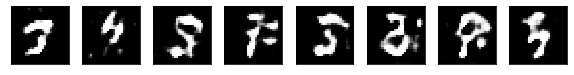

[Step 1200] D Loss: 0.6542; G Loss: 1.2866


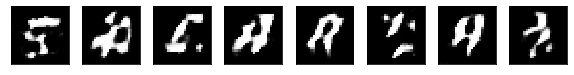

[Step 1400] D Loss: 0.5441; G Loss: 1.1970


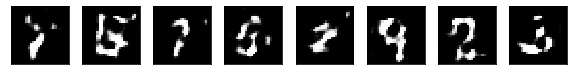

[Step 1600] D Loss: 0.7024; G Loss: 1.0025


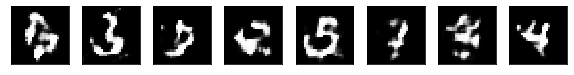

[Step 1800] D Loss: 0.6720; G Loss: 1.3497


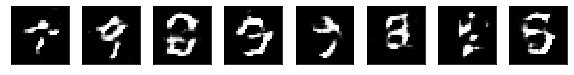

[Step 2000] D Loss: 0.6657; G Loss: 1.4607


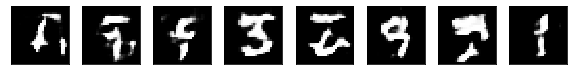

[Step 2200] D Loss: 0.7840; G Loss: 0.8791


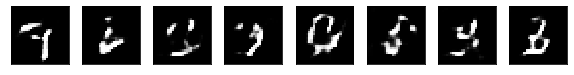

[Step 2400] D Loss: 0.6687; G Loss: 1.0813


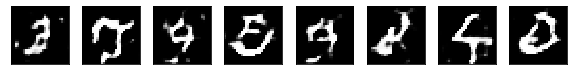

[Step 2600] D Loss: 0.6377; G Loss: 1.0218


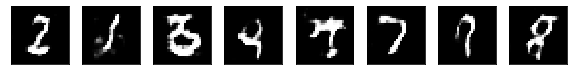

[Step 2800] D Loss: 0.5408; G Loss: 1.2987


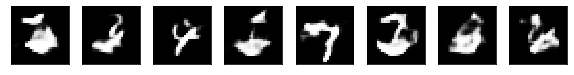

[Step 3000] D Loss: 0.5826; G Loss: 0.7747


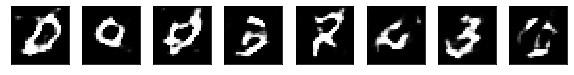

[Step 3200] D Loss: 0.6046; G Loss: 1.2247


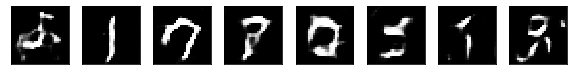

[Step 3400] D Loss: 0.6166; G Loss: 0.9074


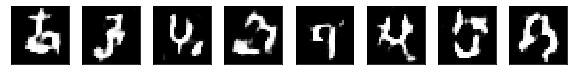

[Step 3600] D Loss: 0.7173; G Loss: 0.8473


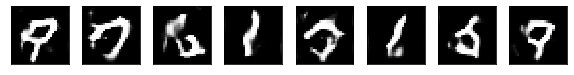

[Step 3800] D Loss: 0.6460; G Loss: 0.8922


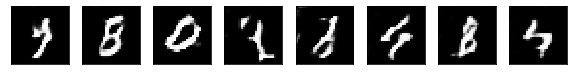

[Step 4000] D Loss: 0.7606; G Loss: 0.9356


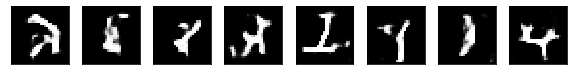

[Step 4200] D Loss: 0.8397; G Loss: 0.9671


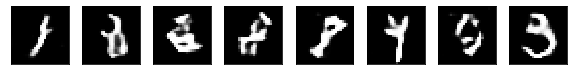

[Step 4400] D Loss: 0.7560; G Loss: 0.9462


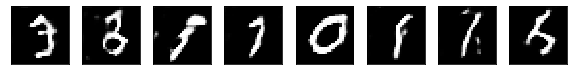

[Step 4600] D Loss: 0.6691; G Loss: 0.9061


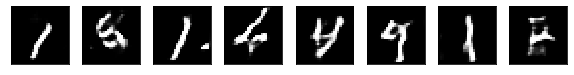

[Step 4800] D Loss: 0.5213; G Loss: 1.0011


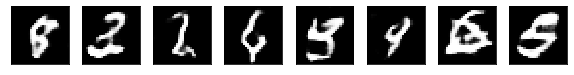

[Step 5000] D Loss: 0.6925; G Loss: 0.7535


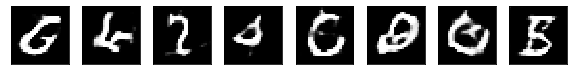

[Step 5200] D Loss: 0.8152; G Loss: 0.6278


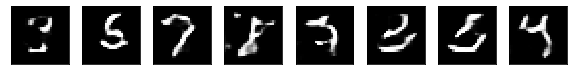

[Step 5400] D Loss: 0.6226; G Loss: 0.8183


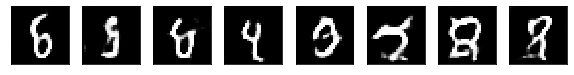

[Step 5600] D Loss: 0.7497; G Loss: 0.8760


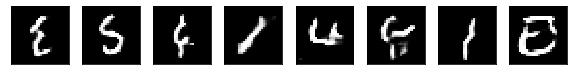

[Step 5800] D Loss: 0.7530; G Loss: 0.9151


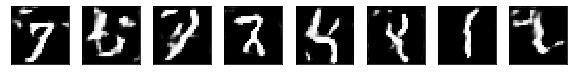

[Step 6000] D Loss: 0.7047; G Loss: 0.9899


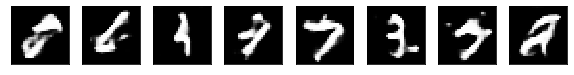

[Step 6200] D Loss: 0.7940; G Loss: 0.9090


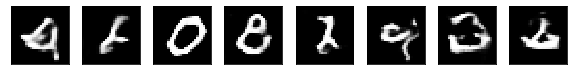

[Step 6400] D Loss: 0.6350; G Loss: 1.0084


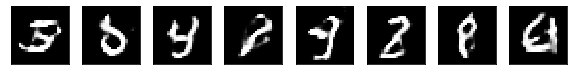

[Step 6600] D Loss: 0.5693; G Loss: 0.9464


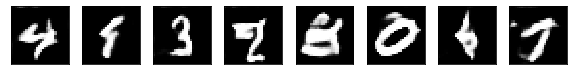

[Step 6800] D Loss: 0.6290; G Loss: 0.8067


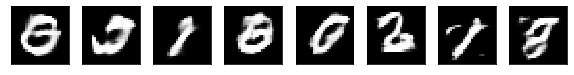

[Step 7000] D Loss: 0.6719; G Loss: 0.7303


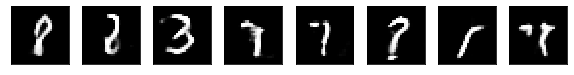

[Step 7200] D Loss: 0.5871; G Loss: 1.0510


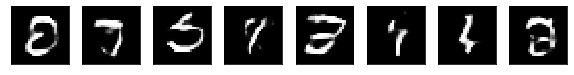

[Step 7400] D Loss: 0.5659; G Loss: 1.1327


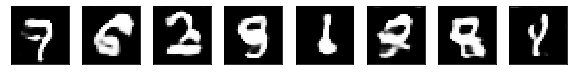

In [0]:
for step, true_images in enumerate(train_ds):
    
    # Train Discriminator
    
    noise = np.random.normal(0, 1, (HALF_BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    syntetic_images = generator.predict(noise)
    x_combined = np.concatenate((
        true_images, 
        syntetic_images))
    y_combined = np.concatenate((
        np.ones((HALF_BATCH_SIZE, 1), np.float32), 
        np.zeros((HALF_BATCH_SIZE, 1), np.float32)))
    
    with tf.GradientTape() as tape:
        logits = discriminator(x_combined, training=True)
        d_loss_value = sigmoid_cross_entropy(y_combined, logits)
    grads = tape.gradient(d_loss_value, discriminator.trainable_variables)
    optimizer.apply_gradients(zip(grads, discriminator.trainable_variables))
    
    # Train Generator
    
    noise = np.random.normal(0, 1, (BATCH_SIZE, INPUT_DIM)).astype(np.float32)
    y_mislabled = np.ones((BATCH_SIZE, 1), np.float32)
    
    with tf.GradientTape() as tape:
        syntetic = generator(noise, training=True)
        logits = discriminator(syntetic, training=False)
        g_loss_value = sigmoid_cross_entropy(y_mislabled, logits)
    grads = tape.gradient(g_loss_value, generator.trainable_variables)
    optimizer.apply_gradients(zip(grads, generator.trainable_variables))
    
    # Check intermediate results
    
    if step % 200 == 0:
        print('[Step %2d] D Loss: %.4f; G Loss: %.4f' % (
            step, d_loss_value.numpy(), g_loss_value.numpy()))
        noise = np.random.normal(0, 1, (8, INPUT_DIM)).astype(np.float32)
        syntetic_images = generator.predict(noise)
        plot_digits(syntetic_images)


## Тестирование свёрточного генератора

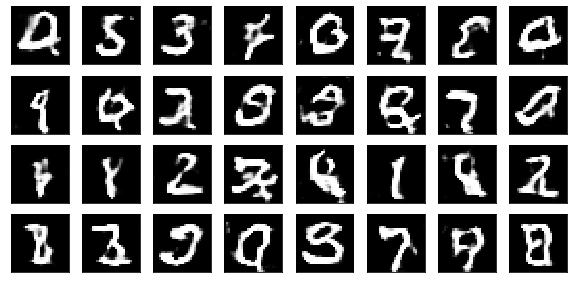

In [0]:
noise = np.random.normal(0, 1, (32, INPUT_DIM)).astype(np.float32)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)

## Интерполяция в латентном пространстве

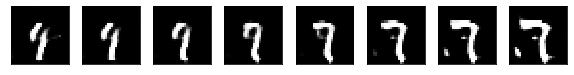

In [0]:
noise_1 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise_2 = np.random.normal(0, 1, (INPUT_DIM)).astype(np.float32)
noise = np.linspace(noise_1, noise_2, 8)
syntetic_images = generator.predict(noise)
plot_digits(syntetic_images)